# Imports

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install --quiet tensorflow_io

     |████████████████████████████████| 24.1MB 67.1MB/s 
     |████████████████████████████████| 2.5MB 47.3MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import Audio

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import models, layers, optimizers, applications, callbacks

# Params

In [ ]:
### --- Data --- ###
ROOT_PATH = 'drive/MyDrive/Birds/'
DIRECTORY = ROOT_PATH + 'data_30s/train/'

### --- Spectrograms --- ###
TARGET_SAMPLE_RATE = 16000
TARGET_SPLIT_DURATION_SEC = 10
NFFT=400
WINDOW=400
STRIDE=100

### --- Dataset --- ###
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
NUM_TARGETS = 50
NUM_RECORDS = 1650
RECORDS_PER_SPECIES = 33
BUFFER_SIZE = 10

# Data

In [ ]:
# Get y_train
y_train = pd.read_csv(DIRECTORY + 'y_train.csv')
matching_table = pd.read_csv(ROOT_PATH + 'matching_table.csv')

# Preprocessing

## Functions

### Generate tensor

In [ ]:
def generate_tensor(file_path, label, 
                    split=True, output_rate=TARGET_SAMPLE_RATE):
    '''
    Objective : Generate tensor from file path and return all steps
    Input : file_path , label = integer between 0 and 49
    Output : tf.Tensor shape(x,), label, input_rate, output_rate
    '''
    
    # 1 - Convert audio file to AudioTensor
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype='float32')
    
    # 2 - Convert AudioTensor to tf Tensor and get rate
    tensor = audio_tensor.to_tensor()
    input_rate = tf.cast(audio_tensor.rate, tf.int64)
    
    # 3 - Resample to output_rate
    output_rate = np.int64(output_rate)
    tensor = tfio.audio.resample(tensor, input_rate, output_rate, name=None)
        
    # 5 - Split randomly
    if split==True:
        split_index = output_rate * TARGET_SPLIT_DURATION_SEC
        tensor = tensor[:split_index]

# split_index = output_rate * TARGET_SPLIT_DURATION_SEC 
# split_start = min(int(tf.random.uniform((), minval=0, maxval=5*output_rate)),
#                   int(tensor.shape[0] - split_index))
# split_end = int(split_start + split_index)
# tensor = tensor[split_start:split_end]
        
    # 6 - Harmonize tensor shape 
    if tensor.dtype == tf.int16:
        tensor = tf.cast(tensor, tf.float32)
    
    # 7 - Convert stereo to mono and remove last dimension
    tensor = tf.reduce_mean(tensor, 1)
    
    return tensor, label, input_rate, output_rate

### Generate spectrogram

In [ ]:
def generate_spectrogram(file_path, label,
                         split=True, output_rate=TARGET_SAMPLE_RATE,  
                         transpose=True,
                         nfft=NFFT, window=WINDOW, stride=STRIDE):
    '''
    Objective : Generate spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Transpose output if asked
    if transpose == True:
        spectrogram = tf.transpose(spectrogram, perm=[1, 0])

    # 4 - Expand dim to get channel dimension
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram, label

### Generate mel spectrogram

In [ ]:
def generate_mel_spectrogram(file_path, label,
                             split=True, output_rate=TARGET_SAMPLE_RATE,
                             transpose=True,
                             nfft=NFFT, window=WINDOW, stride=STRIDE,
                             rate=TARGET_SAMPLE_RATE, mels=128, fmin=0, fmax=8000):
    '''
    Objective : Generate mel spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Convert to mel spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)
    
    # 4 - Transpose output if asked
    if transpose == True:
        mel_spectrogram = tf.transpose(mel_spectrogram, perm=[1, 0])

    # 5 - Expand dim to get channel dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
    
    return mel_spectrogram, label

### Generate db scale mel spectrogram

In [ ]:
def generate_db_scale_mel_spectrogram(file_path, label,
                                      split=True, output_rate=TARGET_SAMPLE_RATE,
                                      transpose=True,
                                      nfft=NFFT, window=WINDOW, stride=STRIDE,
                                      rate=TARGET_SAMPLE_RATE, mels=128, fmin=0, fmax=8000,
                                      top_db=80):
    '''
    Objective : Generate db scale mel spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Convert to mel spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)
    
    # 4 - Convert to db scale mel spectrogram
    db_scale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=top_db)
    
    # 5 - Transpose output if asked
    if transpose == True:
        db_scale_mel_spectrogram = tf.transpose(db_scale_mel_spectrogram, perm=[1, 0])

    # 6 - Expand dim to get channel dimension
    db_scale_mel_spectrogram = tf.expand_dims(db_scale_mel_spectrogram, axis=-1)
        
    return db_scale_mel_spectrogram, label

### Data augmentation

In [ ]:
def augment(spectrogram, label):

    # 1 - Time/frequency masks on spectrograms
    # Keep 50% original spectrograms, 25% vertical, 25% horizontal
    rand_index = tf.random.uniform((), minval=0, maxval=1)

    if rand_index < 0.5:
        spectrogram = spectrogram[:,:,0]
    elif rand_index < 0.75:
        spectrogram = tfio.audio.freq_mask(spectrogram[:,:,0], param=20)
    else:
        spectrogram = tfio.audio.time_mask(spectrogram[:,:,0], param=20)
    
    # 2 - Random brightness
    spectrogram = tf.image.random_brightness(spectrogram, max_delta=0.1)
    
    # 3 - Expand dim to get channel dimension (1)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram, label

### Convert gray to rgb

In [ ]:
def convert_gray_rgb(spectrogram, label):

    # 9 - Duplicate 2 times to get 3 channels
    spectrogram = tf.image.grayscale_to_rgb(spectrogram)

    return spectrogram, label

### One hot encode target

In [ ]:
def one_hot_encode_target(spectrogram, label):
    depth = NUM_TARGETS
    ohe_label = tf.one_hot(label, depth)
    return spectrogram, ohe_label

## Tests

### Random split

In [ ]:
# 1 - Test file
print("# 1 - Test file\n")

path_test = DIRECTORY + y_train[y_train['Target']==1].loc[33, 'Path']
label_test = 1
print('path_test:', path_test)
print('label_test:', label_test)

# 2 - Generating tensor
print("\n# 2 - Generating tensor\n")
 
output_rate=TARGET_SAMPLE_RATE

    # Convert audio file to AudioTensor
audio_tensor = tfio.audio.AudioIOTensor(path_test, dtype='float32')

    # Convert AudioTensor to tf Tensor and get rate
tensor = audio_tensor.to_tensor()
input_rate = tf.cast(audio_tensor.rate, tf.int64)

    # Resample to output rate
output_rate = np.int64(output_rate)
tensor = tfio.audio.resample(tensor, input_rate, output_rate, name=None)
    
    # Split randomly

split_index = output_rate * TARGET_SPLIT_DURATION_SEC 
split_start = min(int(tf.random.uniform((), minval=0, maxval=5*output_rate)),
                  int(tensor.shape[0] - split_index))
split_end = int(split_start + split_index)
tensor = tensor[split_start:split_end]
    
    # Harmonize tensor shape >>> TO DO : test if necessary after step 1 ?
if tensor.dtype == tf.int16:
    tensor = tf.cast(tensor, tf.float32)

    # Convert stereo to mono and remove last dimension
tensor = tf.reduce_mean(tensor, 1)

print('split_start:', split_start, '; type:', type(split_start))
print('split_end:', split_end, '; type:', type(split_end))
print('split_index:', split_index, '; type:', type(split_index))


### Data augmentation

In [ ]:
# 1 - Test file
print("# 1 - Test file\n")

path_test = DIRECTORY + y_train[y_train['Target']==1].loc[33, 'Path']
label_test = 1
file_name_test = path_test.split('/')[-1]
print('path_test:', path_test)
print('label_test:', label_test)

# 2 - Generating spectrogram & augmented spectrogram
print("\n# 2 - Generating db_scale_me_spectrogram\n")

spectrogram_test, label_test = generate_db_scale_mel_spectrogram(path_test, label_test)

plt.figure(figsize=(12,4), constrained_layout=False)
plt.imshow(spectrogram_test[:,:,0].numpy())
plt.title(f"Spectrogram");

augmented_spectrogram_test, label_test = augment(spectrogram_test, label_test)

plt.figure(figsize=(12,4), constrained_layout=False)
plt.imshow(augmented_spectrogram_test[:,:,0].numpy())
plt.title(f"Augmented spectrogram");


# Dataset

## Functions

### Train val split

In [ ]:
def train_val_split(df, train_split=0.8):
    '''
    Objective: split df in df_train and df_val, both shuffled
    Input: df
    Output: df_train and df_val, balanced
    '''

    path_list = list(df['Path'])
    path_list_train = []
    path_list_val = []

    split_index = int(train_split * RECORDS_PER_SPECIES) # 

    for i in range(0, NUM_RECORDS, RECORDS_PER_SPECIES):

        # for each species, put 0:26 records in path_list_train
        for j in range(0, split_index):
            path_list_train.append(path_list[i+j])

        # and put 26:33 records in path_list_val
        for k in range(split_index, RECORDS_PER_SPECIES):
            path_list_val.append(path_list[i+k])

    df_train = df[df['Path'].isin(path_list_train)].reset_index(drop=True)
    df_val = df[df['Path'].isin(path_list_val)].reset_index(drop=True)

    return df_train, df_val

### Generate dataset

In [ ]:
def generate_dataset(df, directory=DIRECTORY, batch_size=BATCH_SIZE, spectrogram='spectrogram', channels=1, shuffle=True):

    '''
    Objective: generate prefetch dataset from pandas dataframe
    Params: spectrogram=['spectrogram', 'mel', 'db_scale_mel'], channels=[1,3]
    Input: pandas dataframe
    Output: prefetch shuffled dataset
    '''

    # 1 - Generate tensorflow dataset
    file_paths = directory + df['Path'].values
    labels = df['Target'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # 2 - Generate spectrogram from path column
    if spectrogram=='spectrogram':
        dataset = dataset.map(generate_spectrogram)
    elif spectrogram=='mel':
        dataset = dataset.map(generate_mel_spectrogram)
    elif spectrogram=='db_scale_mel':
        dataset = dataset.map(generate_db_scale_mel_spectrogram)

    # 3 - Data augmentation
    dataset = dataset.map(augment)

    # 4 - Convert to 3 channels spectrogram
    if channels==3:
        dataset = dataset.map(convert_gray_rgb)

    # 5 - One hot encode target column
    dataset = dataset.map(one_hot_encode_target)

    # 6 - Generate prefetch dataset
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

# Modeling

## Functions

### Plot history

In [ ]:
def plot_history(history):

    plt.figure(figsize=(12,4), constrained_layout=False)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title('Loss', fontsize=14)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.title('Accuracy', fontsize=14)
    plt.legend();

### Generate model

In [ ]:
def generate_model(input_shape_model):
    densenet_model = applications.DenseNet169(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape_model,
        pooling=None)

    densenet_model.trainable = False

    for layer in densenet_model.layers:
      if 'conv5' in layer.name:
        layer.trainable = False
      else:
        layer.trainable = False

    model_transfer = models.Sequential()
    model_transfer.add(densenet_model)
    model_transfer.add(layers.Dropout(rate=0.2)) 
    model_transfer.add(layers.GlobalAveragePooling2D())
    model_transfer.add(layers.Flatten())
    model_transfer.add(layers.Dense(50, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.01)
    model_transfer.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model_transfer


## Modeling iterations

### Previous iterations

1) 30 epochs
  - Score: ~43%
  - Notebook: `philippe_test`
  - Model: `model_densenet169_v1`

2) 100 epochs, without data augmentation
  - Score: ~53%
  - Notebook: `transfer_learning_01`
  - Model: `model_densenet169_v2`

3) Data augmentation #1
  - Mask (50% time, 50% frequency) 
  - Score: ~50%
  - Notebook: `transfer_learning_02`
  - Model: `model_densenet169_v3`



### New try ! 🤞

4) Data augmentation #2
  - Mask (50% none, 25% time, 25% frequency) + random brightness (0.1)
  - Score: ~55%
  - Notebook: `transfer_learning_03`
  - Model: `model_densenet169_v4`


# 1 - Generating datasets


Input shape: (128, 1600, 3)

# 2 - Instantiating model

51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 4, 50, 1664)       12642880  
_________________________________________________________________
dropout (Dropout)            (None, 4, 50, 1664)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                83250     
Total params: 12,726,130
Trainable params: 83,250
Non-trainable params: 12,642,880
_____________________

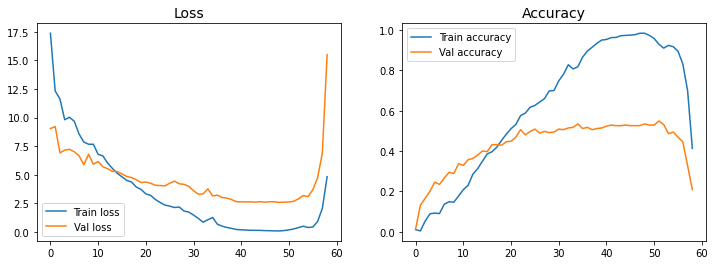

In [ ]:
# --- Params --- #
SPECTROGRAM_TYPE = 'mel'

# 1 - Generating datasets
print("\n# 1 - Generating datasets\n")

df_train, df_val = train_val_split(y_train)
ds_train = generate_dataset(df_train, batch_size=BATCH_SIZE, spectrogram=SPECTROGRAM_TYPE, channels=3)
ds_val = generate_dataset(df_val, batch_size=BATCH_SIZE, spectrogram=SPECTROGRAM_TYPE, channels=3, shuffle=False)

input_shape_model = next(iter(ds_train))[0].shape[1:]

print("\nInput shape:", input_shape_model)

# 2 - Instantiating model
print("\n# 2 - Instantiating model\n")

model_transfer = generate_model(input_shape_model)
model_transfer.summary()

# 3 - Fitting!
print("\n# 3 - Fitting!\n")

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_transfer = model_transfer.fit(
    ds_train,
    validation_data=ds_val,
    epochs=150,
    callbacks=[es],
    verbose=1)

plot_history(history_transfer)

### Saving model

In [ ]:
model_transfer.save(ROOT_PATH + "models/model_densenet169_v4")

INFO:tensorflow:Assets written to: drive/MyDrive/Birds/models/model_densenet169_v4/assets
